In [8]:
import numpy as np
import pandas as pd
#%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import wordcloud
from wordcloud import WordCloud

In [9]:
from services import DBDataToPandasLoader
from database.handlers import DatabaseHandler

db_handler = DatabaseHandler()
db_telegram_loader = DBDataToPandasLoader(db_handler)
channels = db_telegram_loader.get_channels()

Connected to MongoDB


In [10]:
db_telegram_loader.get_messages_df_by_channel_id(channels['id'][0]).head()
most_recent_messages_split = 1
current_channel_id = channels['id'][2]

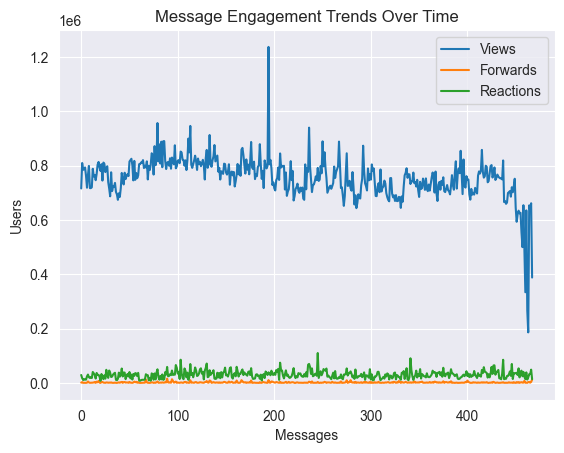

In [11]:
# Message Engagement Trends Over Time
# Dynamic variables: included_columns, is_group_by_date
messages_df = db_telegram_loader.get_messages_df_by_channel_id(current_channel_id)[:-most_recent_messages_split]
included_columns = {'views': 'Views', 'forwards': 'Forwards', 'reactions': 'Reactions'}
x = range(len(messages_df))

is_group_by_date = False

if is_group_by_date:
    messages_df = messages_df.groupby(['date'])[list(included_columns.keys())].sum().reset_index()
    x = messages_df['date']

for k, v in included_columns.items():
    sns.lineplot(x=x, y=messages_df[k], label=v)

plt.xlabel('Messages')
plt.ylabel('Users')
plt.title('Message Engagement Trends Over Time')

plt.legend()
plt.show()

{'🤬', '❤', '👀', '😁', '😢', '🔥'}


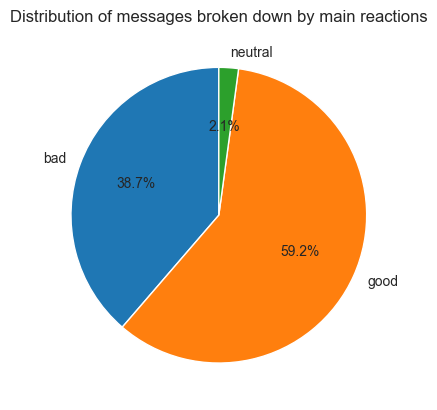

In [12]:
# Emojis
# Dynamic variables: categories
emojis_df = db_telegram_loader.get_all_emojis_reactions_in_chat(current_channel_id)
print(emojis_df)
categories = {'good': ['❤', '👍', '🔥', '😁'], 'bad': ['👎','🤬', '😢'], 'neutral': ['👀']}

messages_df = db_telegram_loader.get_messages_df_by_channel_id(current_channel_id)[:-most_recent_messages_split]

messages_df['category'] = messages_df['main_emoji_reaction'].map({v: k for k, values in categories.items() for v in values})
grouped_by_categories_df = messages_df.groupby(['category'])['id'].count().reset_index()
categories_count = grouped_by_categories_df['id']
labels = grouped_by_categories_df['category']

plt.pie(categories_count, labels=labels, autopct='%1.1f%%', startangle=90)

plt.title('Distribution of messages broken down by main reactions')

plt.show()


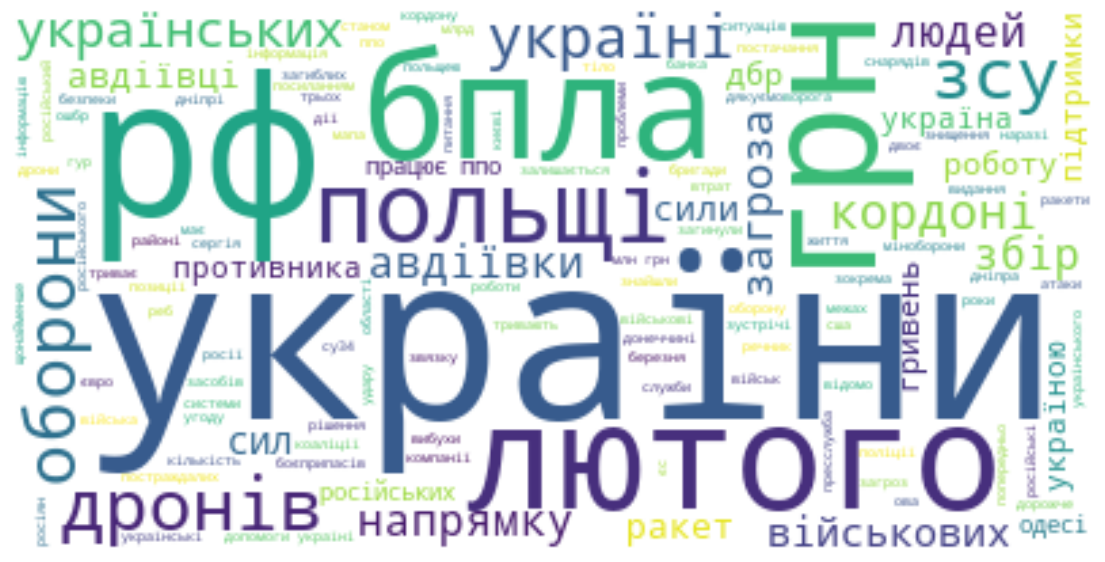

In [13]:
import re
import string

### Stop words ###

needed_languages = ['english', 'ukrainian']

all_stopwords = []

def custom_stopwords(language):
    files_paths = {'ukrainian': '../../data/additional/stopwords_ua.txt'}
    stopwords = pd.read_csv(files_paths[language], header=None, names=['words'])
    return list(stopwords.words)

nltk_languages = stopwords.fileids()
custom_stopwords_languages = ['ukrainian']

for lang in needed_languages:
    if lang in nltk_languages:
        all_stopwords.extend(stopwords.words(lang))
    elif lang in custom_stopwords_languages:
        all_stopwords.extend(custom_stopwords(lang))

def clean_text(text):
    text = "".join([word for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    test_words = [word for word in tokens if word not in all_stopwords]
    return ' '.join(test_words).strip()

################

messages_df = db_telegram_loader.get_messages_df_by_channel_id(current_channel_id)[:-most_recent_messages_split]
# remove stopwords
messages_df['message_nostop'] = messages_df['message'].apply(lambda x: clean_text(x.lower()))
all_words = "".join(messages_df['message_nostop'].tolist())

wordcloud = WordCloud(background_color='white').generate(all_words)

# display the cloud
plt.figure(figsize=(14, 18))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
